# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_Per_Band/224_band8.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.404454 -0.065860  0.279623 -0.018950  0.353436  0.223552   
      201547  0.164046 -0.279912  0.125948 -0.092586  0.311381 -0.091313   
      201548  0.226342 -0.004646 -0.153378  0.161025 -0.055631 -0.126989   
      201549  0.030989  0.038862 -0.250168  0.138053  0.119237 -0.361689   
      201550 -0.225796  0.247388  0.193340  0.175360 -0.112679 -0.070447   

                     6         7         8         9  ...      1015      1016  \
41001 201546 -0.238083  0.301491  0.017513  0.058784  ... -0.211455 -0.119413   
      201547 -0.261746 -0.603773  0.018815  0.188192  ... -0.179405 -0.000805   
      201548 -0.085751 -0.181040  0.069509 -0.042110  ... -0.263966  0.463458   
      201549 -0.227923 -0.686621  0.141110 -0.393854  ... -0.580254  0.053762   
      201550  0.165248 -0.520760  0.329034  0.121354  ... -0.670146  0.293254   

                  1017      1018      1019      1020      1021      1022  \
41001 201546  0.329139 -0.489306 -0.582317  0.128176  0.561558 -0.120706   
      201547  0.151309 -0.491851 -0.211698 -0.004022 -0.153898 -0.101417   
      201548 -0.309870 -0.283341  0.397133  0.060761  0.106624 -0.538396   
      201549 -0.634662 -0.136573  0.148543  0.143810  0.271836 -0.561334   
      201550 -0.052660 -0.033099 -0.004069  0.198201 -0.417523 -0.008597   

                  1023    Labels  
41001 201546 -0.311336 -0.861740  
      201547 -0.787966 -0.854589  
      201548 -0.081292 -0.856973  
      201549 -0.279745 -0.856973  
      201550 -0.472354 -0.823600  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820 -0.652144 -0.000483 -0.371819  0.097266 -0.139232 -0.246002   
      201821  0.261872  0.020454  0.043720  0.017301  0.163034 -0.061027   
      201822 -0.457974  0.168361  0.048842  0.409691  0.166140 -0.261032   
      201823 -0.001343 -0.242898  0.037339  0.412419 -0.025480  0.159335   
      201824  0.076634 -0.049523 -0.061193 -0.182151  0.707878 -0.140500   

                     6         7         8         9  ...      1015      1016  \
41001 201820 -0.256809  0.092985  0.124264 -0.153187  ...  0.325657  0.525835   
      201821 -0.226625  0.165741 -0.206911 -0.183202  ... -0.268065  0.155530   
      201822 -0.183974 -0.008353  0.134526 -0.464827  ...  0.134037 -0.397434   
      201823  0.201330 -0.311470  0.058695  0.322268  ...  0.314682  0.226647   
      201824  0.611162 -0.404637  0.123876 -0.362569  ... -0.712207 -0.027136   

                  1017      1018      1019      1020      1021      1022  \
41001 201820 -0.012009  0.018735 -0.414727 -0.117460 -0.063599  0.171647   
      201821 -0.236598  0.397119  0.031110  0.281907  0.572680 -0.732058   
      201822 -0.328328 -0.830100  0.007346 -0.207447 -0.124675 -0.096934   
      201823 -0.151675 -0.052633  0.391067  0.690685 -0.491931  0.201485   
      201824 -0.066190  0.387704  0.504935  0.207604  0.561364  0.411014   

                  1023    Labels  
41001 201820  0.266653 -0.949940  
      201821 -0.780826 -0.961859  
      201822  0.041098 -0.940405  
      201823  0.437803 -0.961859  
      201824  0.109880 -0.954708  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 1025)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 1024)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 1024)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

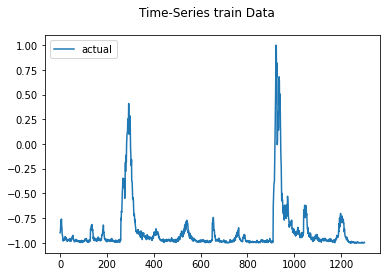

2023-03-14 15:35:56.956449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-14 15:35:56.956487: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 15:35:56.956510: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-14 15:35:56.956755: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 15:35:57.036271: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 52.995
Test RMSE: 63.046
Test sMAPE: 105.274
Test R Squared: -3.113
{'mae': 52.995350286274245, 'rmse': 63.046074087482985, 'smape': 105.273976476982, 'r2': -3.1129942055618525}


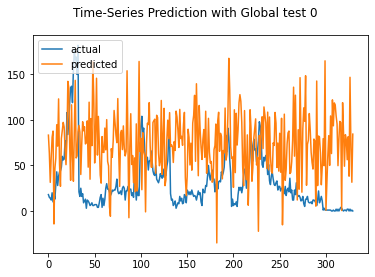

Test MAE: 51.533
Test RMSE: 60.214
Test sMAPE: 104.403
Test R Squared: -2.752
{'mae': 51.533163554740675, 'rmse': 60.21420196197448, 'smape': 104.40266447420812, 'r2': -2.7518016618337255}


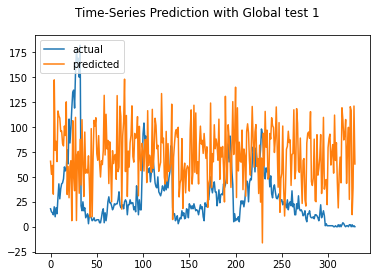

Test MAE: 43.840
Test RMSE: 55.734
Test sMAPE: 100.293
Test R Squared: -2.214
{'mae': 43.83996442628629, 'rmse': 55.73433112533339, 'smape': 100.29295440383018, 'r2': -2.2143087357958953}


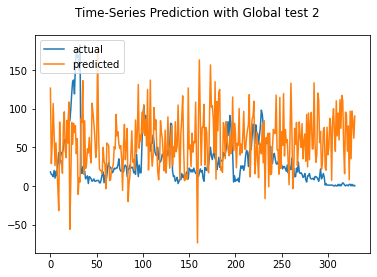

Test MAE: 44.080
Test RMSE: 55.469
Test sMAPE: 100.961
Test R Squared: -2.184
{'mae': 44.08020340457107, 'rmse': 55.46938017681433, 'smape': 100.96102909531523, 'r2': -2.1838208884052746}


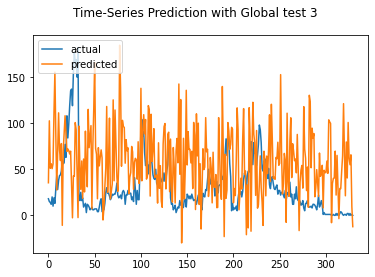

Test MAE: 52.887
Test RMSE: 60.911
Test sMAPE: 106.370
Test R Squared: -2.839
{'mae': 52.88654970689253, 'rmse': 60.91068530459439, 'smape': 106.36962464525286, 'r2': -2.8390960090398742}


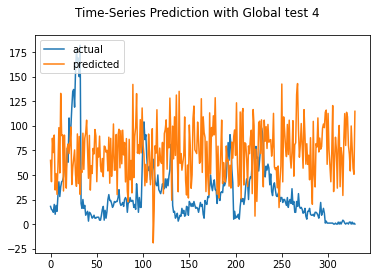

Test MAE: 32.850
Test RMSE: 42.112
Test sMAPE: 100.065
Test R Squared: -0.835
{'mae': 32.85048699505402, 'rmse': 42.111502704643144, 'smape': 100.06487702900206, 'r2': -0.835031314191051}


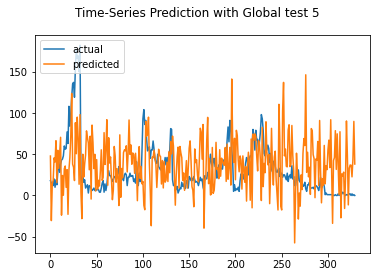

Test MAE: 46.866
Test RMSE: 55.953
Test sMAPE: 103.602
Test R Squared: -2.240
{'mae': 46.866278779055136, 'rmse': 55.952783484024074, 'smape': 103.60213830665396, 'r2': -2.2395552725441807}


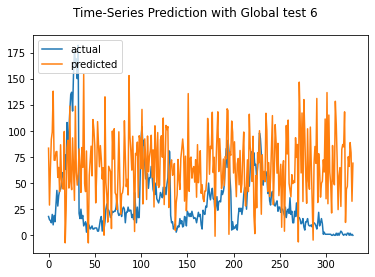

Test MAE: 40.957
Test RMSE: 50.143
Test sMAPE: 98.065
Test R Squared: -1.602
{'mae': 40.956904502529085, 'rmse': 50.143361022108316, 'smape': 98.06502410822685, 'r2': -1.601769887155064}


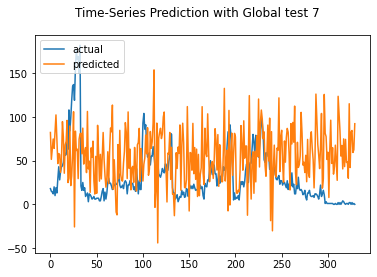

Test MAE: 38.899
Test RMSE: 48.044
Test sMAPE: 100.694
Test R Squared: -1.388
{'mae': 38.899430416208325, 'rmse': 48.0438689412822, 'smape': 100.69380123383682, 'r2': -1.38845987007362}


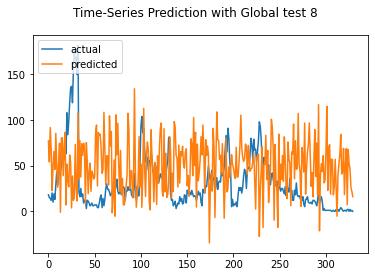

Test MAE: 48.158
Test RMSE: 56.490
Test sMAPE: 102.935
Test R Squared: -2.302
{'mae': 48.15848654689211, 'rmse': 56.49020842169949, 'smape': 102.93475056253237, 'r2': -2.3020858168843885}


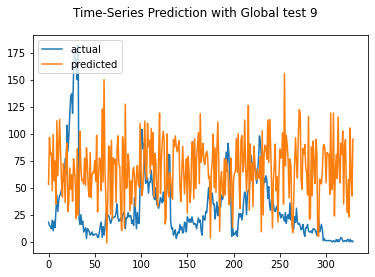

Test MAE: 63.432
Test RMSE: 71.561
Test sMAPE: 112.650
Test R Squared: -4.299
{'mae': 63.43150409062704, 'rmse': 71.56050174950688, 'smape': 112.64958468980231, 'r2': -4.298936993697785}


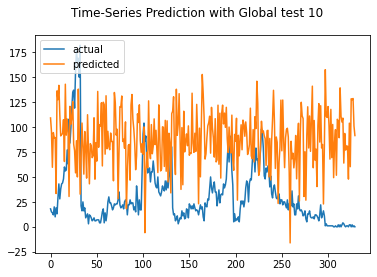

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 42.660
Test RMSE: 55.626
Test sMAPE: 126.235
Test R Squared: -2.202
{'mae': 42.65992650985718, 'rmse': 55.62642129047607, 'smape': 126.23509984435249, 'r2': -2.2018740393962557}


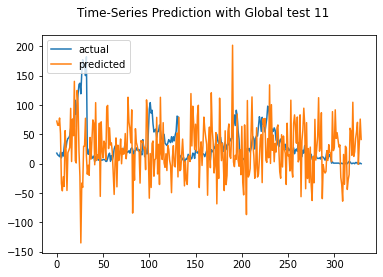

Test MAE: 61.353
Test RMSE: 69.719
Test sMAPE: 111.752
Test R Squared: -4.030
{'mae': 61.353302661577864, 'rmse': 69.71858393840951, 'smape': 111.7522396317277, 'r2': -4.029665657912319}


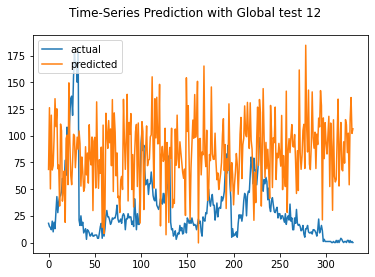

Test MAE: 42.555
Test RMSE: 52.134
Test sMAPE: 103.653
Test R Squared: -1.812
{'mae': 42.55524279041724, 'rmse': 52.133512358437656, 'smape': 103.65260223724688, 'r2': -1.8123927673653717}


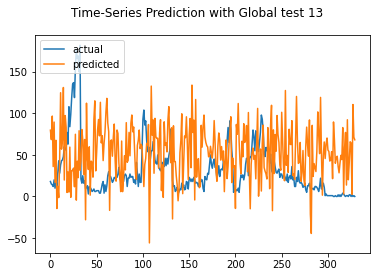

Test MAE: 60.341
Test RMSE: 69.581
Test sMAPE: 109.789
Test R Squared: -4.010
{'mae': 60.34131356441613, 'rmse': 69.58081597134742, 'smape': 109.78910455891193, 'r2': -4.00980747543659}


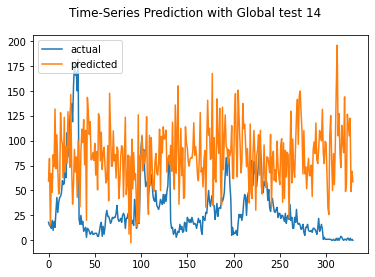

Test MAE: 37.241
Test RMSE: 48.308
Test sMAPE: 114.719
Test R Squared: -1.415
{'mae': 37.24090629888303, 'rmse': 48.30755082744902, 'smape': 114.71899246768989, 'r2': -1.414749254481582}


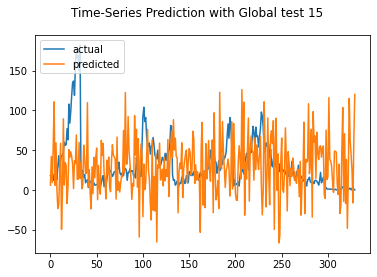

Test MAE: 46.546
Test RMSE: 54.136
Test sMAPE: 105.878
Test R Squared: -2.033
{'mae': 46.54582079974088, 'rmse': 54.13629871373762, 'smape': 105.8781081723365, 'r2': -2.0326278664542268}


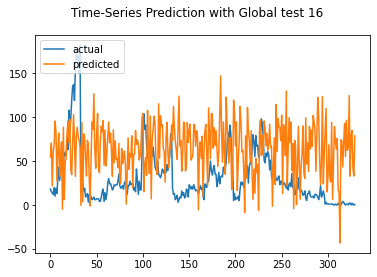

Test MAE: 62.924
Test RMSE: 70.396
Test sMAPE: 113.211
Test R Squared: -4.128
{'mae': 62.92436916177923, 'rmse': 70.39554592006432, 'smape': 113.21072190234091, 'r2': -4.127815185822529}


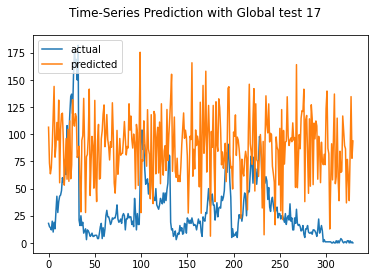

Test MAE: 58.695
Test RMSE: 66.446
Test sMAPE: 110.461
Test R Squared: -3.569
{'mae': 58.694848559119485, 'rmse': 66.4463572255255, 'smape': 110.4607941740353, 'r2': -3.5686128300643665}


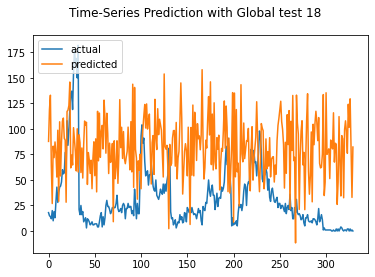

Test MAE: 43.625
Test RMSE: 54.353
Test sMAPE: 103.286
Test R Squared: -2.057
{'mae': 43.625144719806585, 'rmse': 54.352948547114714, 'smape': 103.28598146202681, 'r2': -2.0569491816979304}


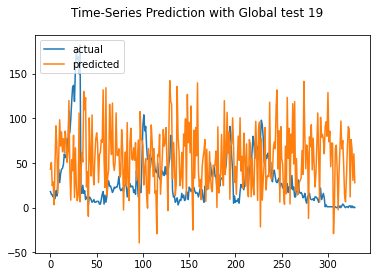

Test MAE: 54.526
Test RMSE: 65.277
Test sMAPE: 107.280
Test R Squared: -3.409
{'mae': 54.52615821686658, 'rmse': 65.27700590550452, 'smape': 107.28003395289437, 'r2': -3.4092269582145365}


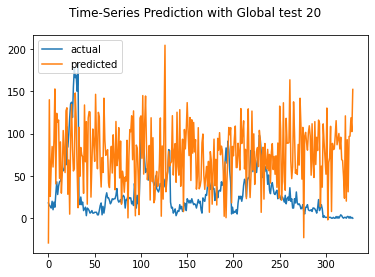

Test MAE: 43.223
Test RMSE: 52.532
Test sMAPE: 99.211
Test R Squared: -1.856
{'mae': 43.22295876271797, 'rmse': 52.53186850880621, 'smape': 99.21069581320862, 'r2': -1.8555363878093587}


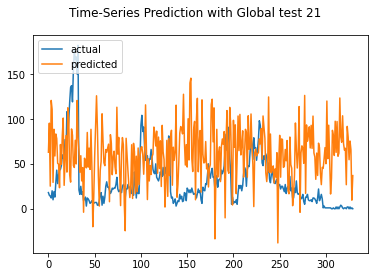

Test MAE: 42.794
Test RMSE: 51.285
Test sMAPE: 98.593
Test R Squared: -1.722
{'mae': 42.79449872103604, 'rmse': 51.284718005178625, 'smape': 98.5927880311646, 'r2': -1.7215602008724162}


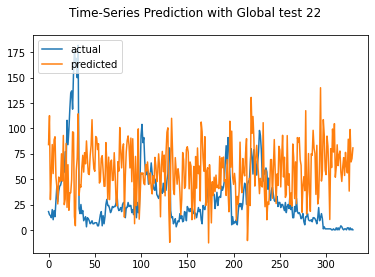

Test MAE: 48.618
Test RMSE: 58.010
Test sMAPE: 104.217
Test R Squared: -2.482
{'mae': 48.61849967855396, 'rmse': 58.00955957463436, 'smape': 104.21695745378472, 'r2': -2.482099189275734}


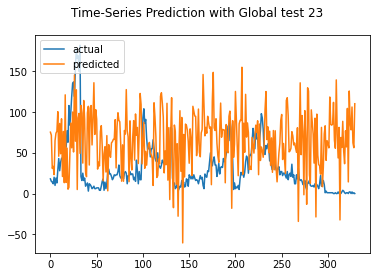

Test MAE: 34.522
Test RMSE: 45.978
Test sMAPE: 104.819
Test R Squared: -1.188
{'mae': 34.52158512599541, 'rmse': 45.97833101307672, 'smape': 104.81910064833193, 'r2': -1.1875017383850266}


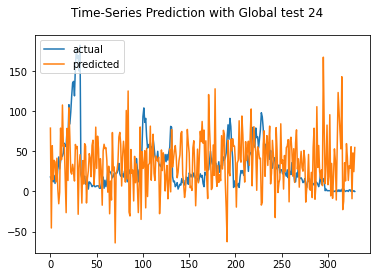

Test MAE: 36.797
Test RMSE: 45.482
Test sMAPE: 97.232
Test R Squared: -1.141
{'mae': 36.79716922171188, 'rmse': 45.482461206478526, 'smape': 97.23196501289488, 'r2': -1.14057237903703}


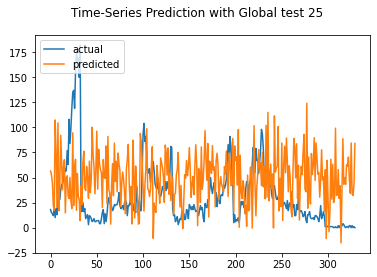

Test MAE: 40.869
Test RMSE: 51.632
Test sMAPE: 101.152
Test R Squared: -1.759
{'mae': 40.868617328008014, 'rmse': 51.63175035359776, 'smape': 101.15232487415355, 'r2': -1.758517211562499}


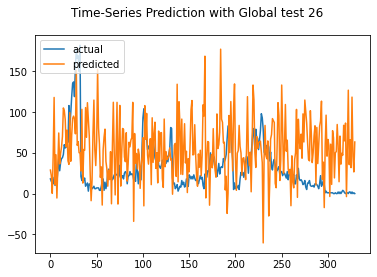

Test MAE: 44.571
Test RMSE: 54.039
Test sMAPE: 101.961
Test R Squared: -2.022
{'mae': 44.57101436049649, 'rmse': 54.03882938879538, 'smape': 101.96145322768119, 'r2': -2.02171754923258}


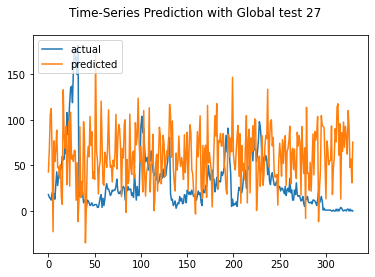

Test MAE: 51.720
Test RMSE: 61.496
Test sMAPE: 105.730
Test R Squared: -2.913
{'mae': 51.71968840469014, 'rmse': 61.496388322352445, 'smape': 105.73027919456153, 'r2': -2.913282696348888}


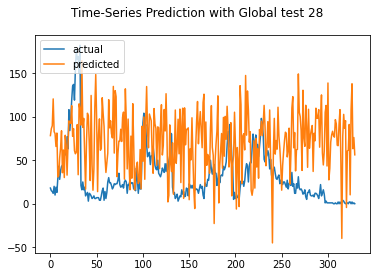

Test MAE: 69.812
Test RMSE: 79.736
Test sMAPE: 116.294
Test R Squared: -5.579
{'mae': 69.81202915365046, 'rmse': 79.73566345971297, 'smape': 116.29386663763025, 'r2': -5.578808216027538}


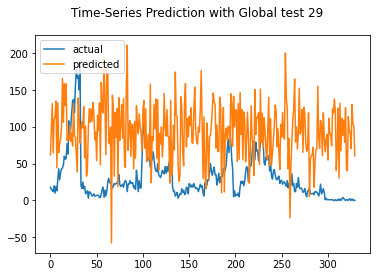

Test MAE: 33.611
Test RMSE: 42.907
Test sMAPE: 91.085
Test R Squared: -0.905
{'mae': 33.61094977494442, 'rmse': 42.9065390943305, 'smape': 91.08495139041295, 'r2': -0.9049736459167987}


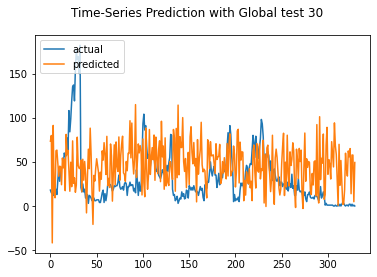

Test MAE: 53.326
Test RMSE: 62.305
Test sMAPE: 105.859
Test R Squared: -3.017
{'mae': 53.326003801461425, 'rmse': 62.30490176880619, 'smape': 105.85879936835708, 'r2': -3.0168575716486794}


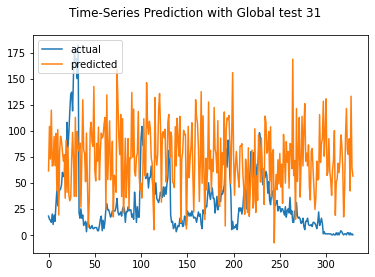

Test MAE: 36.412
Test RMSE: 47.382
Test sMAPE: 103.562
Test R Squared: -1.323
{'mae': 36.411589832739395, 'rmse': 47.38246263737067, 'smape': 103.5617705605812, 'r2': -1.323150039012384}


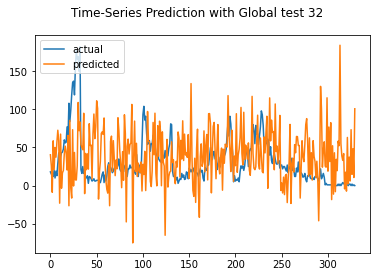

Test MAE: 38.748
Test RMSE: 47.917
Test sMAPE: 105.289
Test R Squared: -1.376
{'mae': 38.74833623586279, 'rmse': 47.91702060849958, 'smape': 105.28867180895826, 'r2': -1.3758642071351113}


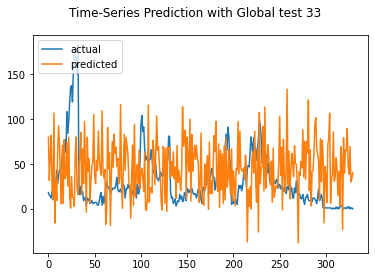

Test MAE: 68.935
Test RMSE: 77.712
Test sMAPE: 115.926
Test R Squared: -5.249
{'mae': 68.93508605957031, 'rmse': 77.71212391769213, 'smape': 115.92647777153968, 'r2': -5.249129994355369}


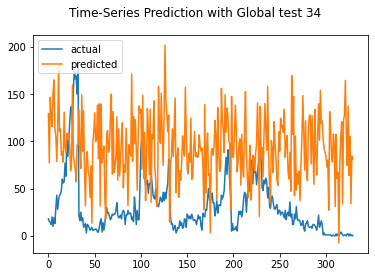

Test MAE: 41.971
Test RMSE: 51.202
Test sMAPE: 104.667
Test R Squared: -1.713
{'mae': 41.971128973997, 'rmse': 51.2022743622568, 'smape': 104.66717964511534, 'r2': -1.712817050988087}


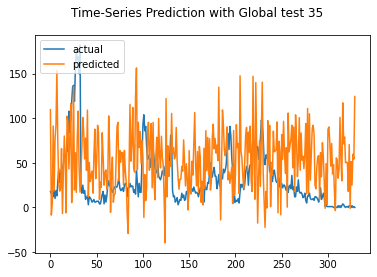

Test MAE: 64.348
Test RMSE: 73.076
Test sMAPE: 112.253
Test R Squared: -4.526
{'mae': 64.34774262110392, 'rmse': 73.07566965433678, 'smape': 112.25334535603815, 'r2': -4.525703903153122}


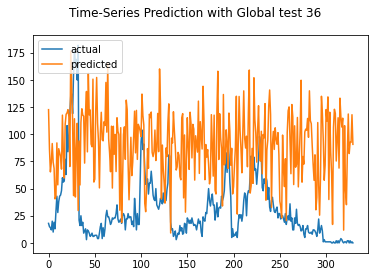

Test MAE: 50.031
Test RMSE: 60.624
Test sMAPE: 104.274
Test R Squared: -2.803
{'mae': 50.031394431807776, 'rmse': 60.624433508266144, 'smape': 104.27402100740221, 'r2': -2.803096878453947}


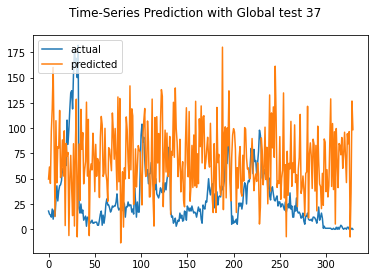

Test MAE: 47.866
Test RMSE: 56.442
Test sMAPE: 102.112
Test R Squared: -2.296
{'mae': 47.86626111323183, 'rmse': 56.44164378846992, 'smape': 102.11234602651673, 'r2': -2.2964106509273456}


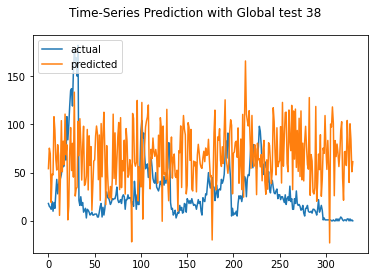

Test MAE: 36.676
Test RMSE: 45.649
Test sMAPE: 100.623
Test R Squared: -1.156
{'mae': 36.67563503727769, 'rmse': 45.648576174074044, 'smape': 100.62313090525029, 'r2': -1.1562368986752265}


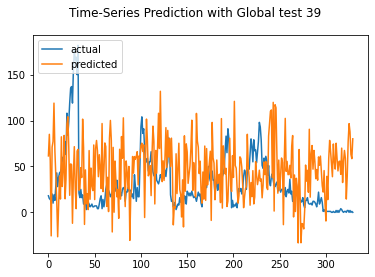

Test MAE: 58.263
Test RMSE: 66.265
Test sMAPE: 108.886
Test R Squared: -3.544
{'mae': 58.26314300045823, 'rmse': 66.26468469550683, 'smape': 108.88607087000044, 'r2': -3.543664681312169}


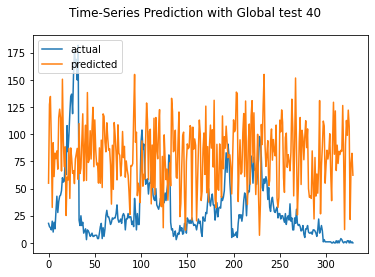

Test MAE: 34.720
Test RMSE: 44.903
Test sMAPE: 106.514
Test R Squared: -1.086
{'mae': 34.72006707173405, 'rmse': 44.90257354499115, 'smape': 106.51428610684641, 'r2': -1.0863370350283899}


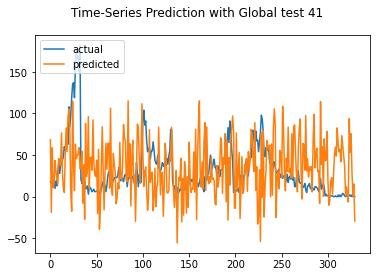

Test MAE: 56.754
Test RMSE: 64.528
Test sMAPE: 108.131
Test R Squared: -3.309
{'mae': 56.75365216515281, 'rmse': 64.52802289854854, 'smape': 108.1305831103385, 'r2': -3.308625220135}


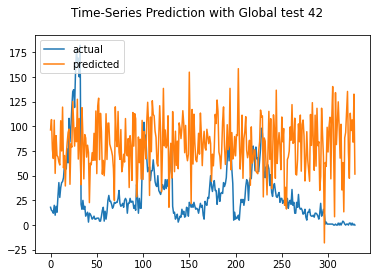

Test MAE: 44.005
Test RMSE: 53.224
Test sMAPE: 103.605
Test R Squared: -1.931
{'mae': 44.005210044889736, 'rmse': 53.224045961228725, 'smape': 103.60529108376522, 'r2': -1.9312831571746707}


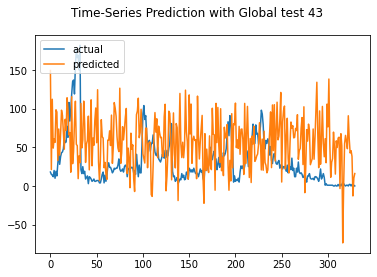

Test MAE: 48.826
Test RMSE: 58.192
Test sMAPE: 104.277
Test R Squared: -2.504
{'mae': 48.82575058214592, 'rmse': 58.191523446578834, 'smape': 104.27661114107963, 'r2': -2.503978686949798}


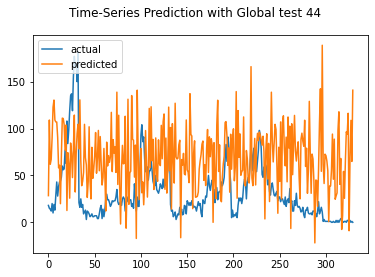

Test MAE: 43.735
Test RMSE: 52.154
Test sMAPE: 99.093
Test R Squared: -1.815
{'mae': 43.73472552714926, 'rmse': 52.153985899627955, 'smape': 99.09299084095797, 'r2': -1.8146021310823115}


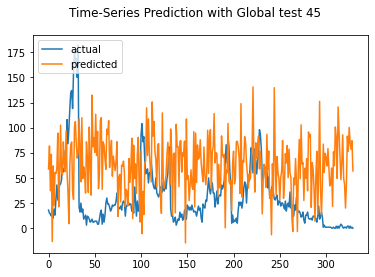

Test MAE: 50.435
Test RMSE: 59.192
Test sMAPE: 104.457
Test R Squared: -2.626
{'mae': 50.43519152583498, 'rmse': 59.192443469783676, 'smape': 104.45698917435436, 'r2': -2.625555333791433}


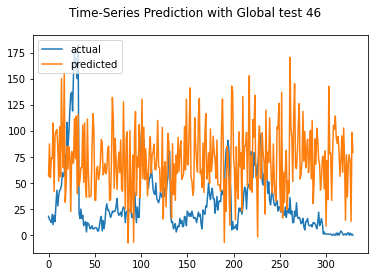

Test MAE: 41.217
Test RMSE: 50.974
Test sMAPE: 97.179
Test R Squared: -1.689
{'mae': 41.21661314603054, 'rmse': 50.97401493396657, 'smape': 97.17868980821156, 'r2': -1.6886835208360993}


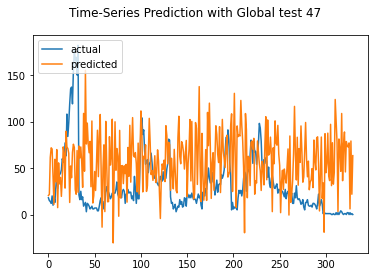

Test MAE: 57.671
Test RMSE: 64.957
Test sMAPE: 111.644
Test R Squared: -3.366
{'mae': 57.67080740079735, 'rmse': 64.95666021030662, 'smape': 111.64429037502698, 'r2': -3.3660567483177575}


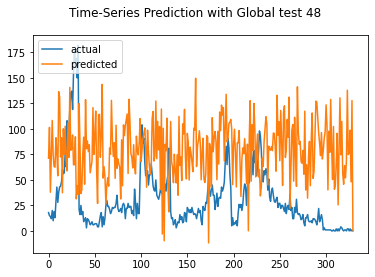

Test MAE: 44.724
Test RMSE: 53.321
Test sMAPE: 100.969
Test R Squared: -1.942
{'mae': 44.72394448320071, 'rmse': 53.32145878589922, 'smape': 100.96911766099237, 'r2': -1.942022884858361}


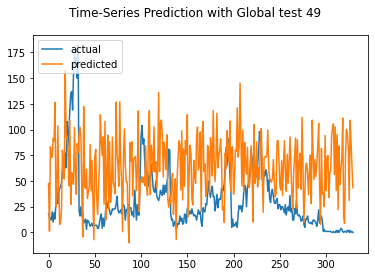

Test MAE: 39.191
Test RMSE: 49.967
Test sMAPE: 107.191
Test R Squared: -1.584
{'mae': 39.190939380544606, 'rmse': 49.96741788273597, 'smape': 107.19100405449858, 'r2': -1.5835437271354067}


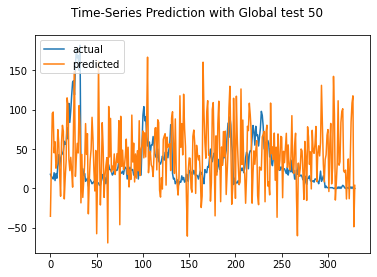

Test MAE: 61.419
Test RMSE: 69.287
Test sMAPE: 110.923
Test R Squared: -3.968
{'mae': 61.41860596049916, 'rmse': 69.28743877231831, 'smape': 110.92292244311882, 'r2': -3.9676503163172416}


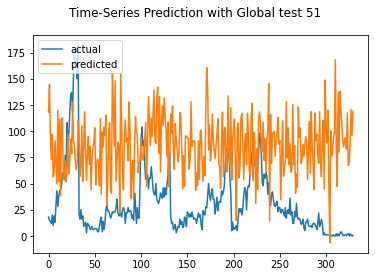

Test MAE: 39.862
Test RMSE: 48.808
Test sMAPE: 102.917
Test R Squared: -1.465
{'mae': 39.862112893660864, 'rmse': 48.808258661014435, 'smape': 102.91651956065158, 'r2': -1.465066437820798}


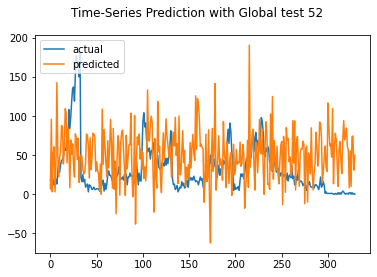

Test MAE: 53.780
Test RMSE: 62.638
Test sMAPE: 107.626
Test R Squared: -3.060
{'mae': 53.77960448987556, 'rmse': 62.63795581658367, 'smape': 107.626182147632, 'r2': -3.0599169893426383}


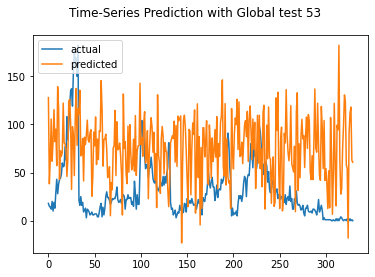

Test MAE: 60.207
Test RMSE: 70.041
Test sMAPE: 109.424
Test R Squared: -4.076
{'mae': 60.207086996598676, 'rmse': 70.04095347190001, 'smape': 109.42421213811771, 'r2': -4.0762862137283316}


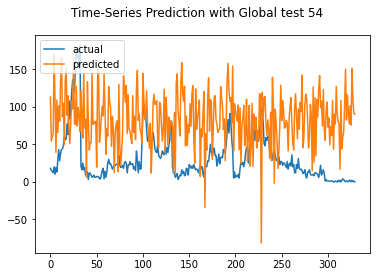

Test MAE: 48.864
Test RMSE: 59.426
Test sMAPE: 103.878
Test R Squared: -2.654
{'mae': 48.8636538001624, 'rmse': 59.425965450018424, 'smape': 103.87817012565283, 'r2': -2.654218348119627}


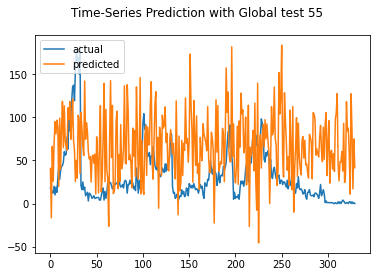

Test MAE: 53.214
Test RMSE: 62.822
Test sMAPE: 106.593
Test R Squared: -3.084
{'mae': 53.21411351344802, 'rmse': 62.82203846267609, 'smape': 106.59259542027425, 'r2': -3.0838149099238237}


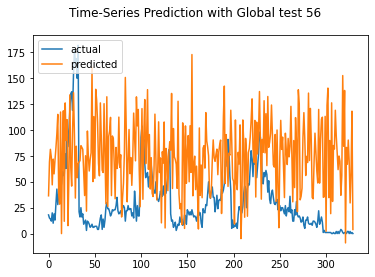

Test MAE: 53.449
Test RMSE: 61.351
Test sMAPE: 108.110
Test R Squared: -2.895
{'mae': 53.44896336992581, 'rmse': 61.350829382352536, 'smape': 108.10978163102995, 'r2': -2.8947795232895057}


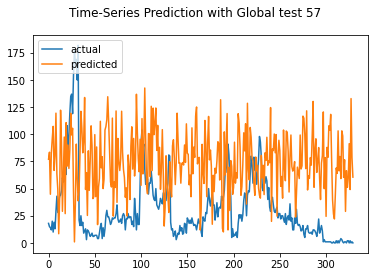

Test MAE: 55.473
Test RMSE: 64.367
Test sMAPE: 107.228
Test R Squared: -3.287
{'mae': 55.47334763642513, 'rmse': 64.36697112150371, 'smape': 107.22838902327938, 'r2': -3.2871447603284834}


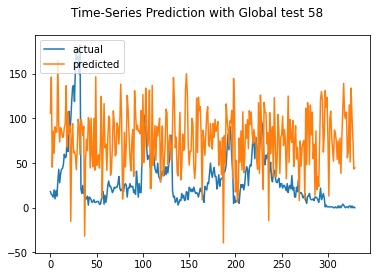

Test MAE: 41.557
Test RMSE: 50.615
Test sMAPE: 99.260
Test R Squared: -1.651
{'mae': 41.557333696249756, 'rmse': 50.61543093849729, 'smape': 99.26023974216675, 'r2': -1.650988716349822}


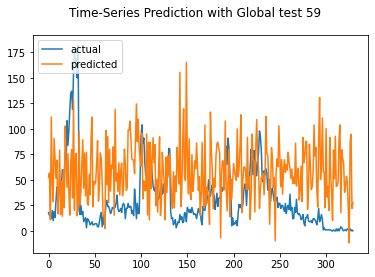

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 44.154
Test RMSE: 55.063
Test sMAPE: 111.428
Test R Squared: -2.137
{'mae': 44.15374296777176, 'rmse': 55.06340874829194, 'smape': 111.42835952659895, 'r2': -2.137387690006773}


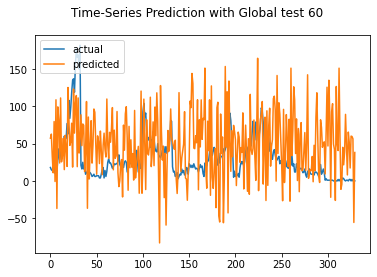

Test MAE: 49.575
Test RMSE: 57.293
Test sMAPE: 104.528
Test R Squared: -2.397
{'mae': 49.574817486965294, 'rmse': 57.29317791937247, 'smape': 104.52775033067654, 'r2': -2.3966267543720776}


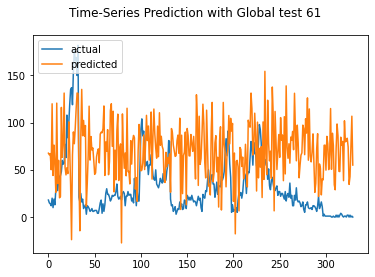

Test MAE: 38.823
Test RMSE: 48.692
Test sMAPE: 108.287
Test R Squared: -1.453
{'mae': 38.82312456170718, 'rmse': 48.69219143774086, 'smape': 108.28678235522565, 'r2': -1.4533564021776777}


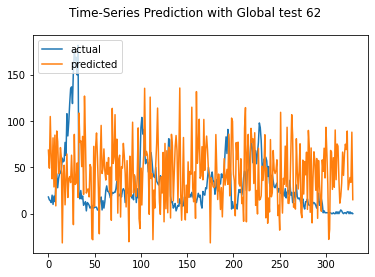

Test MAE: 41.566
Test RMSE: 49.732
Test sMAPE: 98.206
Test R Squared: -1.559
{'mae': 41.56601716081301, 'rmse': 49.732193548212216, 'smape': 98.20608315547872, 'r2': -1.5592766362927684}


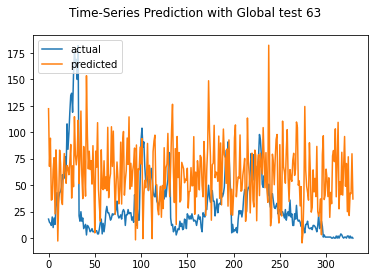

Test MAE: 42.163
Test RMSE: 51.414
Test sMAPE: 99.192
Test R Squared: -1.735
{'mae': 42.162754966454074, 'rmse': 51.414168606778816, 'smape': 99.19181631834954, 'r2': -1.7353168230631972}


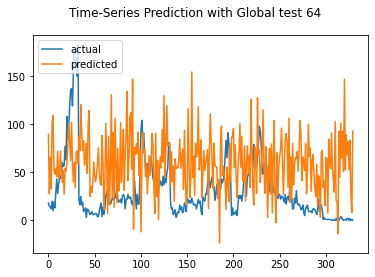

Test MAE: 46.631
Test RMSE: 56.486
Test sMAPE: 105.338
Test R Squared: -2.302
{'mae': 46.63148265083631, 'rmse': 56.48639566891278, 'smape': 105.33823404863489, 'r2': -2.3016400896556966}


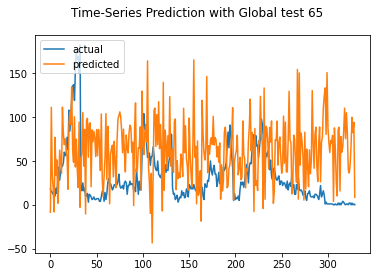

Test MAE: 44.801
Test RMSE: 53.940
Test sMAPE: 101.661
Test R Squared: -2.011
{'mae': 44.80140195904356, 'rmse': 53.94019979408645, 'smape': 101.66137454591588, 'r2': -2.010697369727851}


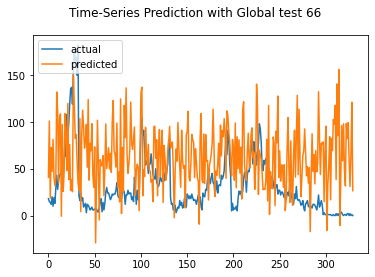

Test MAE: 47.613
Test RMSE: 56.980
Test sMAPE: 101.752
Test R Squared: -2.360
{'mae': 47.61251390991789, 'rmse': 56.979728460368825, 'smape': 101.75187597657703, 'r2': -2.359562710650715}


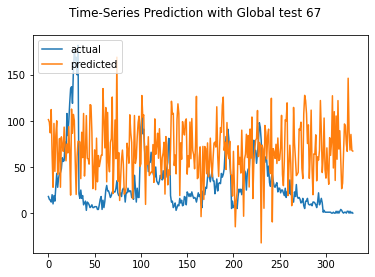

Test MAE: 52.950
Test RMSE: 61.487
Test sMAPE: 106.185
Test R Squared: -2.912
{'mae': 52.94979388641589, 'rmse': 61.48722639573811, 'smape': 106.18474048214985, 'r2': -2.9121167567189086}


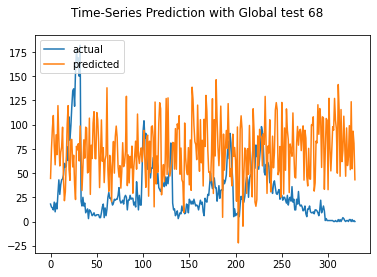

Test MAE: 45.741
Test RMSE: 54.963
Test sMAPE: 101.888
Test R Squared: -2.126
{'mae': 45.74119474129243, 'rmse': 54.96313622666011, 'smape': 101.88755492668322, 'r2': -2.1259714940734686}


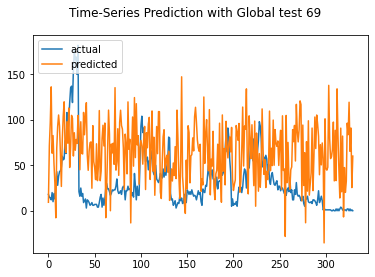

Test MAE: 83.895
Test RMSE: 91.545
Test sMAPE: 124.221
Test R Squared: -7.672
{'mae': 83.89535181739113, 'rmse': 91.54463106691513, 'smape': 124.22119989213944, 'r2': -7.671770171353684}


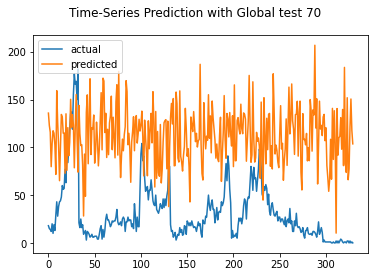

Test MAE: 36.052
Test RMSE: 46.275
Test sMAPE: 100.911
Test R Squared: -1.216
{'mae': 36.05162005099383, 'rmse': 46.275420477521074, 'smape': 100.91148828557418, 'r2': -1.215862199531521}


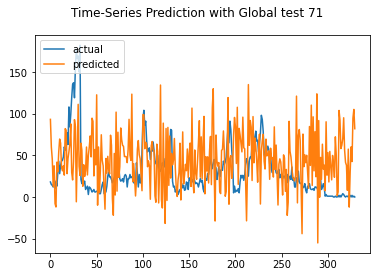

Test MAE: 46.859
Test RMSE: 55.514
Test sMAPE: 100.250
Test R Squared: -2.189
{'mae': 46.858839281400044, 'rmse': 55.51364797258166, 'smape': 100.25026239944806, 'r2': -2.188904665143166}


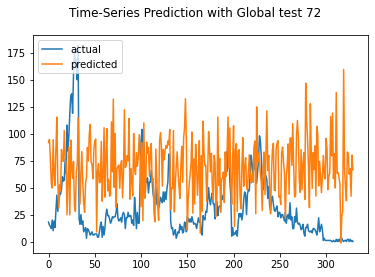

Test MAE: 60.919
Test RMSE: 68.130
Test sMAPE: 111.260
Test R Squared: -3.803
{'mae': 60.91888137224949, 'rmse': 68.13036330560318, 'smape': 111.26041908495588, 'r2': -3.803119714967141}


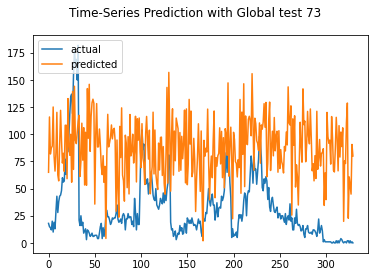

Test MAE: 38.233
Test RMSE: 47.774
Test sMAPE: 102.474
Test R Squared: -1.362
{'mae': 38.23301485307289, 'rmse': 47.774259351713894, 'smape': 102.4737179980723, 'r2': -1.3617282660020176}


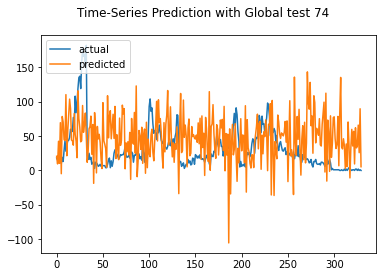

Test MAE: 51.034
Test RMSE: 59.151
Test sMAPE: 106.914
Test R Squared: -2.620
{'mae': 51.0341679948749, 'rmse': 59.15069904571388, 'smape': 106.9143331605021, 'r2': -2.6204434193924016}


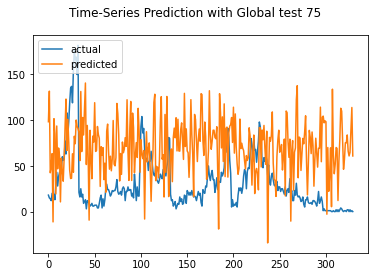

Test MAE: 40.202
Test RMSE: 49.569
Test sMAPE: 100.305
Test R Squared: -1.542
{'mae': 40.20188180840377, 'rmse': 49.56850968653419, 'smape': 100.30504068870073, 'r2': -1.5424576356069188}


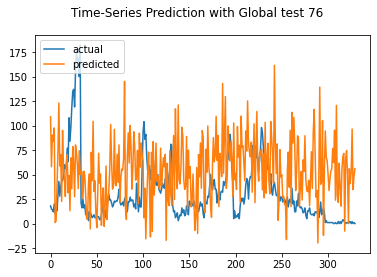

Test MAE: 38.696
Test RMSE: 48.333
Test sMAPE: 98.635
Test R Squared: -1.417
{'mae': 38.69593097567558, 'rmse': 48.333453481515434, 'smape': 98.63491313355978, 'r2': -1.4173395403829923}


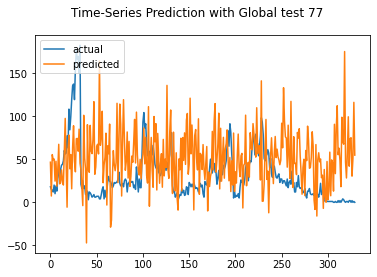

Test MAE: 64.640
Test RMSE: 73.874
Test sMAPE: 112.282
Test R Squared: -4.647
{'mae': 64.64047653024846, 'rmse': 73.87363045517198, 'smape': 112.28242634821699, 'r2': -4.6470402963560655}


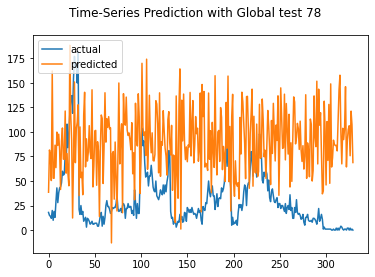

Test MAE: 47.343
Test RMSE: 55.596
Test sMAPE: 102.772
Test R Squared: -2.198
{'mae': 47.34267575271202, 'rmse': 55.59557981643197, 'smape': 102.77239230577479, 'r2': -2.1983245340638957}


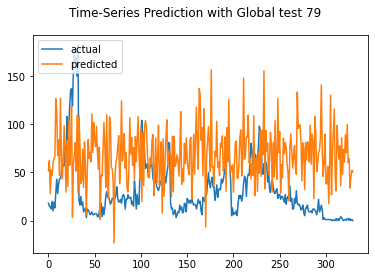

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 47.555
Test RMSE: 60.812
Test sMAPE: 112.713
Test R Squared: -2.827
{'mae': 47.55489015217984, 'rmse': 60.81226037598643, 'smape': 112.71328490571737, 'r2': -2.826698924471848}


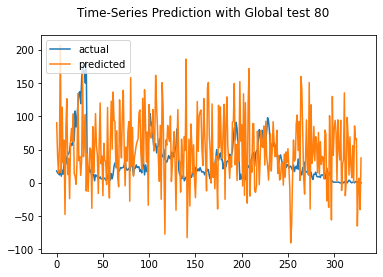

Test MAE: 57.535
Test RMSE: 68.746
Test sMAPE: 108.773
Test R Squared: -3.890
{'mae': 57.53513127384764, 'rmse': 68.74617969621765, 'smape': 108.77281921733524, 'r2': -3.890340958374134}


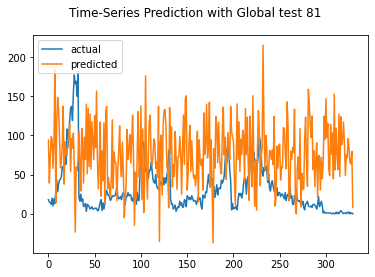

Test MAE: 47.429
Test RMSE: 55.818
Test sMAPE: 101.634
Test R Squared: -2.224
{'mae': 47.42901985717542, 'rmse': 55.8175946415442, 'smape': 101.63445092721581, 'r2': -2.2239198518394914}


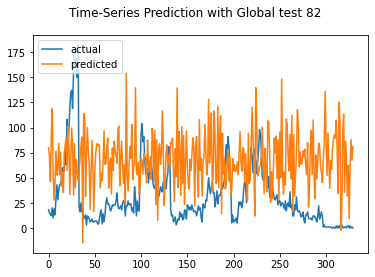

Test MAE: 53.813
Test RMSE: 63.577
Test sMAPE: 108.001
Test R Squared: -3.183
{'mae': 53.813092018438105, 'rmse': 63.577022379852515, 'smape': 108.00083921484104, 'r2': -3.182561827779937}


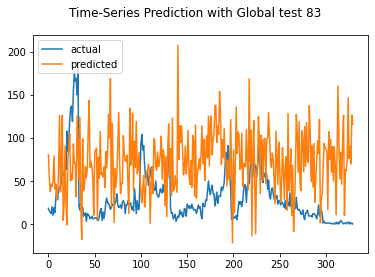

Test MAE: 59.650
Test RMSE: 67.934
Test sMAPE: 110.032
Test R Squared: -3.775
{'mae': 59.650161467176495, 'rmse': 67.93411125673616, 'smape': 110.03205378231695, 'r2': -3.7754884383868914}


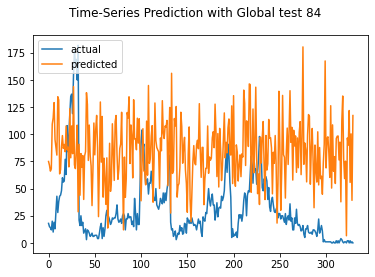

Test MAE: 56.809
Test RMSE: 65.655
Test sMAPE: 109.526
Test R Squared: -3.460
{'mae': 56.808888632239714, 'rmse': 65.65464927628452, 'smape': 109.52618805597312, 'r2': -3.460391433565376}


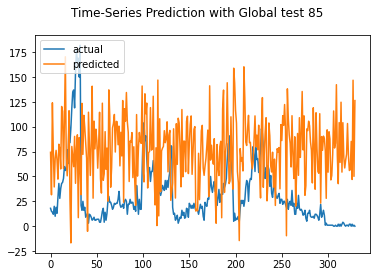

Test MAE: 47.443
Test RMSE: 56.197
Test sMAPE: 100.678
Test R Squared: -2.268
{'mae': 47.44281938003771, 'rmse': 56.196568669871766, 'smape': 100.67761676043892, 'r2': -2.2678461281453868}


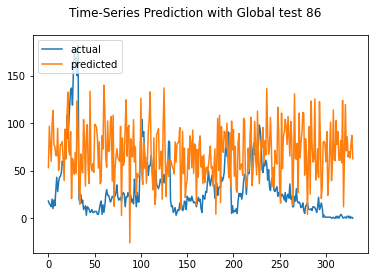

Test MAE: 59.170
Test RMSE: 68.103
Test sMAPE: 110.883
Test R Squared: -3.799
{'mae': 59.16969741655119, 'rmse': 68.10272710953888, 'smape': 110.8834834045968, 'r2': -3.79922385915176}


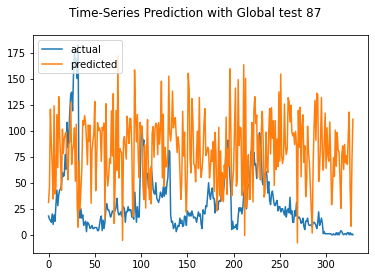

Test MAE: 45.781
Test RMSE: 54.000
Test sMAPE: 99.572
Test R Squared: -2.017
{'mae': 45.780511357567526, 'rmse': 53.999851109160154, 'smape': 99.57242547913324, 'r2': -2.0173599835702065}


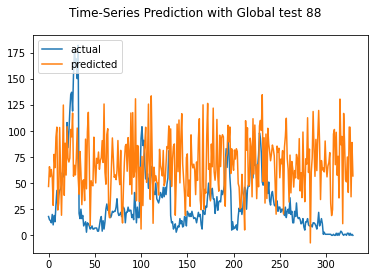

Test MAE: 46.732
Test RMSE: 55.458
Test sMAPE: 100.075
Test R Squared: -2.183
{'mae': 46.73167357589259, 'rmse': 55.45787925810744, 'smape': 100.07501437513622, 'r2': -2.182500770204509}


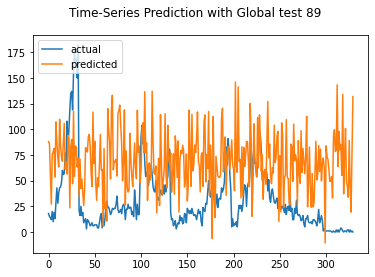

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 35.057
Test RMSE: 47.294
Test sMAPE: 112.044
Test R Squared: -1.314
{'mae': 35.057214651776086, 'rmse': 47.29405698874502, 'smape': 112.0444918285288, 'r2': -1.314489113547177}


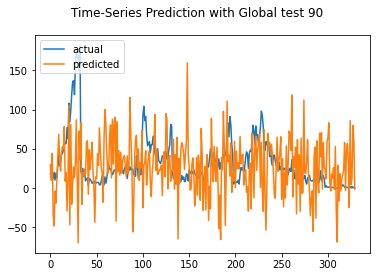

Test MAE: 43.141
Test RMSE: 54.463
Test sMAPE: 104.989
Test R Squared: -2.069
{'mae': 43.140979540709296, 'rmse': 54.46251267261256, 'smape': 104.9887884342444, 'r2': -2.069285937991134}


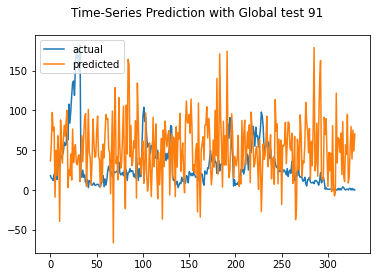

Test MAE: 40.473
Test RMSE: 49.100
Test sMAPE: 98.129
Test R Squared: -1.495
{'mae': 40.47320355691693, 'rmse': 49.099848083141, 'smape': 98.12920123700493, 'r2': -1.4946079294030739}


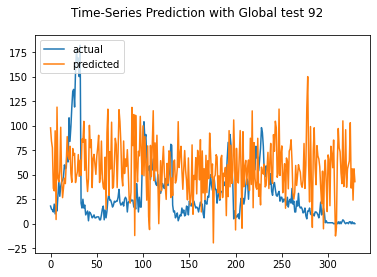

Test MAE: 40.023
Test RMSE: 49.135
Test sMAPE: 95.954
Test R Squared: -1.498
{'mae': 40.02270910812147, 'rmse': 49.13454655720278, 'smape': 95.95414289649737, 'r2': -1.498135014606984}


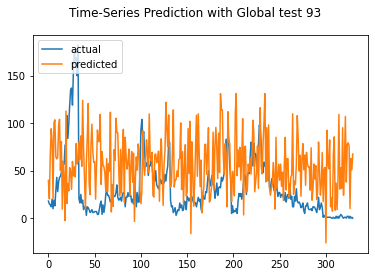

Test MAE: 43.824
Test RMSE: 52.227
Test sMAPE: 104.055
Test R Squared: -1.823
{'mae': 43.8241005888491, 'rmse': 52.227404952841276, 'smape': 104.0546783880608, 'r2': -1.822532143379148}


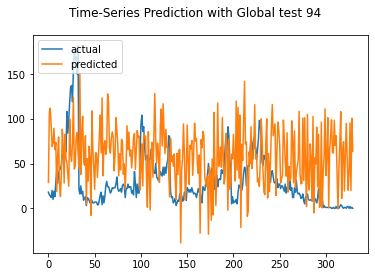

Test MAE: 39.102
Test RMSE: 48.806
Test sMAPE: 95.207
Test R Squared: -1.465
{'mae': 39.10234787220305, 'rmse': 48.80612008240955, 'smape': 95.20711170642508, 'r2': -1.4648504242609977}


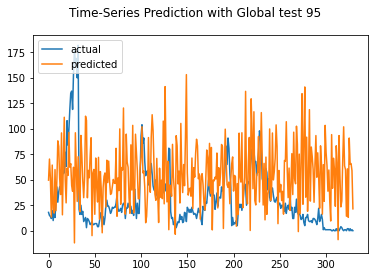

Test MAE: 50.323
Test RMSE: 58.386
Test sMAPE: 104.847
Test R Squared: -2.527
{'mae': 50.32260264483365, 'rmse': 58.385757236528725, 'smape': 104.8472458968055, 'r2': -2.5274091411028388}


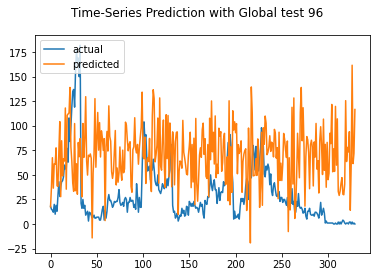

Test MAE: 42.444
Test RMSE: 51.663
Test sMAPE: 100.933
Test R Squared: -1.762
{'mae': 42.44431177133863, 'rmse': 51.66283327219731, 'smape': 100.93254574571505, 'r2': -1.7618395306560757}


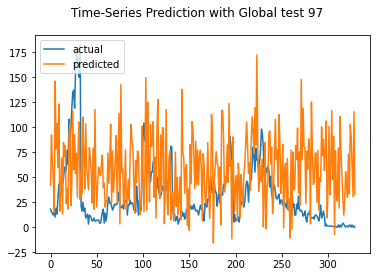

Test MAE: 40.400
Test RMSE: 49.966
Test sMAPE: 97.424
Test R Squared: -1.583
{'mae': 40.40003308166157, 'rmse': 49.965524756899484, 'smape': 97.42391728495907, 'r2': -1.5833479643390036}


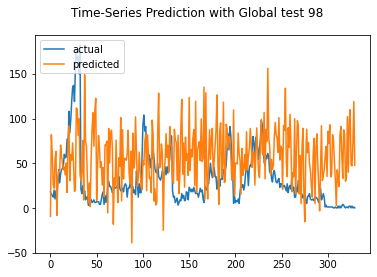

Test MAE: 37.083
Test RMSE: 47.385
Test sMAPE: 104.497
Test R Squared: -1.323
{'mae': 37.083354149803974, 'rmse': 47.38507690447224, 'smape': 104.49740466194254, 'r2': -1.3234063997807026}


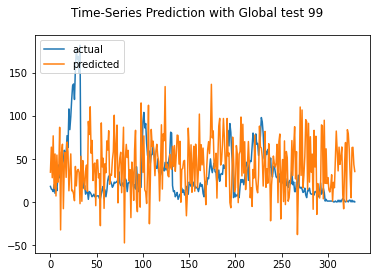

rmse : average=57.246, std=8.808
mae : average=47.949, std=9.214
smape : average=105.028, std=5.702
r2 : average=-2.471, std=1.125


([57.2462437557652, 8.808334854952545],
 [47.94856838140795, 9.21380449607023],
 [105.02797633786909, 5.702052208150455],
 [-2.4713481656678282, 1.125245156512504])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')